In [2]:
from keras import layers
from keras import models
from keras import utils
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, shutil
import cv2

In [3]:
image_size = (512, 512)

#Create a Pandas dataframe for training data for exploratory data analysis
df = pd.read_csv(r'../images/trainLabels.csv')
df

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [4]:
#Total rows of data in our dataframe (-1 due to first row consisting of column headers)
print("Columns: ", len(df.columns), "- Rows: ", len(df.index))

Columns:  2 - Rows:  35126


In [5]:
#Check for any duplicated rows or null values
print(f"There are {df.duplicated().sum()} repeated rows")
print(df.isnull().sum())

There are 0 repeated rows
image    0
level    0
dtype: int64


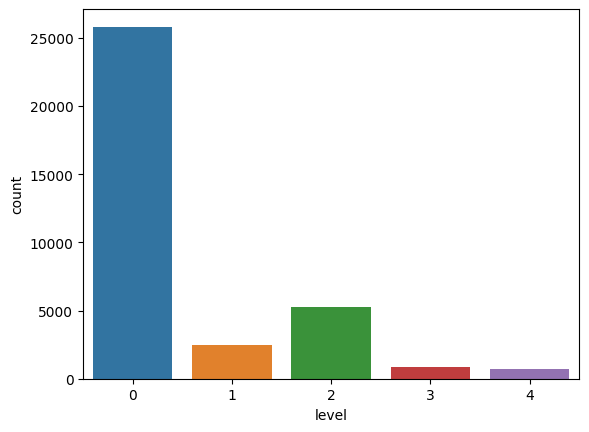

In [6]:
#Visualisation of quantity of images related to their grade of retinopathy
#We'll need to perform data augmentation as there is very low amount of images for each grade in comparison to clean images. 
distribution = sns.countplot(x=df['level'])

In [7]:
base_dir = '../images/train'

#Make new directories for each retinopathy grade

"""
grade_0_dir = os.path.join(base_dir, '0')
os.mkdir(grade_0_dir)

grade_1_dir = os.path.join(base_dir, '1')
os.mkdir(grade_1_dir)

grade_2_dir = os.path.join(base_dir, '2')
os.mkdir(grade_2_dir)

grade_3_dir = os.path.join(base_dir, '3')
os.mkdir(grade_3_dir)

grade_4_dir = os.path.join(base_dir, '4')
os.mkdir(grade_4_dir)
"""

"\ngrade_0_dir = os.path.join(base_dir, '0')\nos.mkdir(grade_0_dir)\n\ngrade_1_dir = os.path.join(base_dir, '1')\nos.mkdir(grade_1_dir)\n\ngrade_2_dir = os.path.join(base_dir, '2')\nos.mkdir(grade_2_dir)\n\ngrade_3_dir = os.path.join(base_dir, '3')\nos.mkdir(grade_3_dir)\n\ngrade_4_dir = os.path.join(base_dir, '4')\nos.mkdir(grade_4_dir)\n"

In [8]:
#Move images from our main training folder and categorise into new folders
"""
for index, row in df.iterrows():
    shutil.move(f"../images/train/{row['image']}.jpeg", f"../images/train/{row['level']}/{row['image']}.jpeg")
"""

'\nfor index, row in df.iterrows():\n    shutil.move(f"../images/train/{row[\'image\']}.jpeg", f"../images/train/{row[\'level\']}/{row[\'image\']}.jpeg")\n'

In [9]:
train_ds = utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode='int',
    color_mode='grayscale',
    batch_size=42,
    image_size=image_size,
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='training',
    crop_to_aspect_ratio=True
)

validation_ds = utils.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode='int',
    color_mode='grayscale',
    batch_size=42,
    image_size=image_size,
    shuffle=True,
    seed=32,
    validation_split=0.2,
    subset='validation',
    crop_to_aspect_ratio=True
)

Found 35126 files belonging to 5 classes.
Using 28101 files for training.
Found 35126 files belonging to 5 classes.
Using 7025 files for validation.


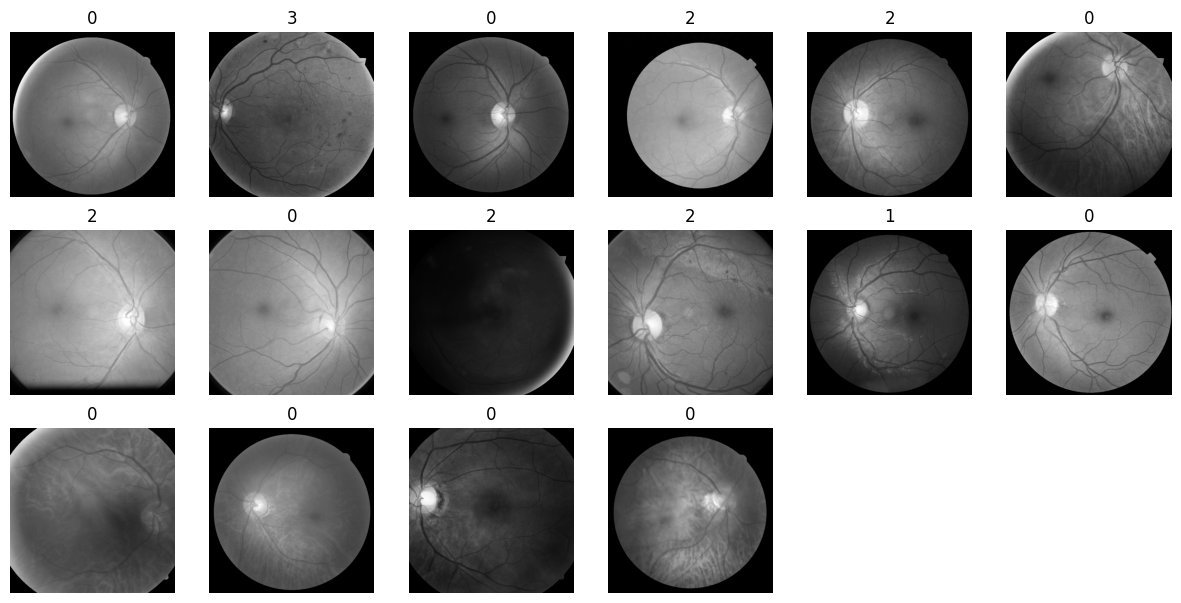

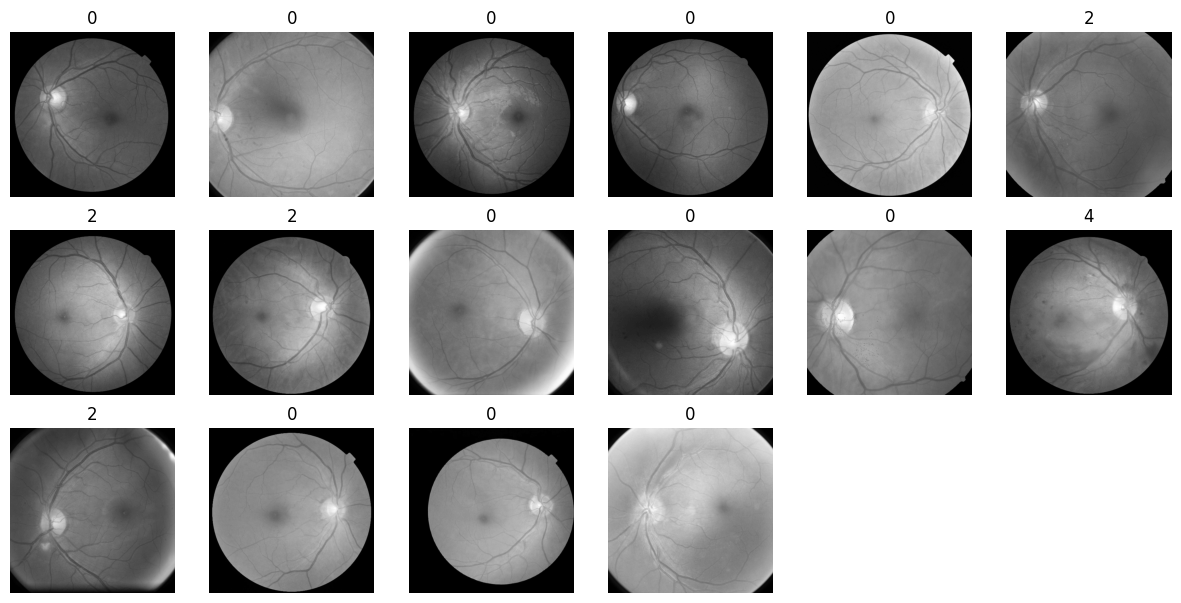

In [11]:
#Display a sample of images from our dataset
plt.figure(figsize=(15, 15))
classes = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(16):
        plot = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')

plt.figure(figsize=(15, 15))
classes = validation_ds.class_names
for images, labels in validation_ds.take(1):
    for i in range(16):
        plot = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(classes[labels[i]])
        plt.axis('off')